# Projeto Eletromagnetismo WPT

O objetivo do projeto consiste na ideação, simulação computacional e construção de um protótipo experimental para uma aplicação real da transmissão de energia elétrica sem fios. O protótipo deve ter um potencial uso por consumidores ou clientes, ou seja, deve atender a uma real necessidade ou situação habitual.

## 1. Introdução

Com a evolução dos dispositivos eletrônicos, a ideia de nos livrarmos dos cabos e carregadores de bateria tornou-se possível, principalmente para telefones celulares . Isso fez com que engenheiros buscassem estratégias diferentes para a transmissão de energia sem fio. 

A primeira evidência de transmissão de energia elétrica através do ar ocorreu quando NikolaTesla, conhecendo as relações entre corrente elétrica e campo magnético, mostrou que uma bobina percorrida por uma corrente alternada poderia induzir força eletromotriz em uma segunda bobina posicionada próxima à primeira. Isso permitiu o surgimento de tecnologias voltadas à geração de energia elétrica.

Os principais avanços que ocorreram nas últimas duas décadas trazem à tona uma estratégia bem-sucedida para se aumentar a eficiência de transmissão entre duas bobinas pelo ar: o acoplamento ressonante. O acoplamento ressonante faz com que o campo magnético entre as bobinas aumente em intensidade, permitindo uma transmissão eficiente a maiores distâncias.

## 2. Modelo eletrodinâmico

![Esquematização do circuito](circuito.png)

A primeira diferença entre o circuito WPT e o do transformador convencional se reflete na existência de capacitores em série e em paralelo no primário e secundário, respectivamente. Os capacitores são necessários para garantir que haja frequência natural de oscilação nos circuitos primário e secundário.

![Esquematização do circuito](circuito_lab.jpeg)

## 3. Simulação

### Importanto bibliotecas

In [9]:
from math import *
from cmath import *
from numpy import linalg
import numpy as np
import matplotlib.pyplot as plt

### Condições iniciais

In [10]:
R1 = R2 = 0.5 # ohms
Rdc = 0.5 # ohms, Rdc significa a resistência da bobina conectada à uma fonte DC
L1 = L2 = 300e-6 # henry
C1 = C2 = 0.1e-6 # farad
Rc = 10 # ohms, resistência da carga
f = 60 # hertz
k = 0.1 # fator de acoplamento

### Função que calcula as correntes do primário e do secundário

In [11]:
def CalcularCorrentes(v1, Rc, f) -> tuple[complex, complex]:
    w = 2*pi*f
    M = sqrt(L1*L2)*k
    XL1 = L1*w*1j
    XL2 = L2*w*1j
    XM = M*w*1j

    XC1 = 1/(C1*w*1j)
    XC2 = 1/(C2*w*1j)

    Z=np.array([[(R1+XL1+XC1), -XM],[-XM, XL2+R2+((Rc * XC2)/(XC2 + Rc))]])
    V=np.array([v1,0])
    I=np.dot(linalg.inv(Z),V)
    return I[0], I[1]

A indutância mútua neste caso é multiplicada pelo fator k porque apenas parte do fluxo magnético produzido por uma das bobinas chega à outra. A indutância mútua é dada por:

$$ M = k\cdot \sqrt{L_1\cdot L_2}$$

### Comparação dos picos de tensão em função da frequência para diferentes valores de capacitância

Temos uma lista da capacitâncias disponíveis para utilizar no projeto, e para cada capacitor existirá um pico de tensão em função da frequência. Portanto, fazemos um gráfico fazendo essa comparação para escolher com qual capacitor trabalhar, assim como a frequência de ressonância

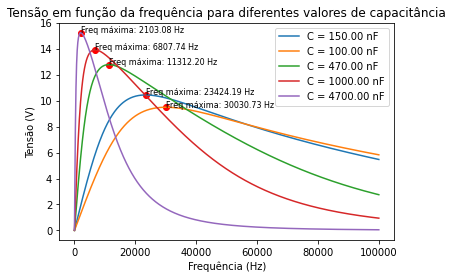

In [12]:
max_f = []
ListaC = [150*1e-9, 0.1*1e-6, 0.47*1e-6, 1e-6, 4.7*1e-6] #lista com os valores de capacitância
lista_fr = np.linspace(1, 100e3, 1000) 
for cap in ListaC:
    C1 = C2 = cap
    lista_V2 = []
    for freq in lista_fr:
        w = 2 * pi * freq
        L1 = L2 = 1 / (w * w * cap)
        XC1 = XC2 = 1 / (cap * 1j * w)
        R1 = Rdc + (2 * Rdc / 100e3) * freq
        R2 = R1
        i1, i2 = CalcularCorrentes(10, Rc, freq)
        i4 = ((XC2 * i2) / (XC2 + Rc))
        lista_V2.append(abs(Rc * i4))

    # Encontrar o índice do valor máximo de lista_V2
    indice_maximo = np.argmax(lista_V2)
    # Obter a frequência correspondente ao valor máximo
    freq_maxima = lista_fr[indice_maximo]
    max_f.append(freq_maxima)

    plt.plot(lista_fr, lista_V2, label=f"C = {cap * 1e9:.2f} nF")
    plt.scatter(freq_maxima, lista_V2[indice_maximo], color='red')  # Marcando o ponto máximo

    # Adicionando texto com o valor máximo
    plt.text(freq_maxima, lista_V2[indice_maximo], f"Freq máxima: {freq_maxima:.2f} Hz", fontsize=8)

plt.xlabel('Frequência (Hz)')
plt.ylabel('Tensão (V)')
plt.title('Tensão em função da frequência para diferentes valores de capacitância')
plt.legend()
plt.show()

Foi escolhido o capacitor de 150 $nF$ porque o seu pico de tensão é mais acentuado e não se altera muito mesmo se variando a frequência em alguns kilohertz

### Cálculo da indutância das bobinas:


Agora é necessário calcular a indutância das bobinas para em seguida calcular os parâmetros físicos como diâmetro e número de voltas através do site Physika

$$ L = \frac{1}{(2\pi \cdot f)^2 \cdot C}$$
$$ L = \frac{1}{(2\pi \cdot 23000)^2} \cdot \frac{1}{150 \cdot 10^{-9}} $$
$$ L = 0.350 mH $$

Após coletar as informações de parâmetros físicos e a montagem da bobina, é necessário medir os valores reais de resistência e indutãncia da bobina, dessa forma obtemos:

- $R1=1.315\Omega$
- $R2=1.509\Omega$
- $L1=0.365 mH$ 
- $L2=0.360 mH$

In [34]:
#Declaração das variáveis após a medição real das bobinas
R1 = 1.315+0.5 # adicionamos meio ohm de resistência por conta dos jumpers do circuito
R2 = 1.509 +0.5
Rdc1 = R1
Rdc2 = R2
L1 = 365.7e-6
L2 = 360.2e-6
C1 = C2 = 150e-9
Rc = 10
f = 23000

### Atualização da função que calcula as correntes

Como estamos trabalhando com uma tensão quadrada na entrada da bobina primária, precisamos fazer uma pequena alteração na amplitude da função senoidal usada na
simulação. 

$$ V_1(t) = \frac{2}{\pi} V_p \cos(\omega t) $$

In [35]:
def CalcularCorrentes_(vp, Rc, f, k) -> tuple[complex, complex]:
    w = 2*pi*f
    M = sqrt(L1*L2)*k
    XL1 = L1*w*1j
    XL2 = L2*w*1j
    XM = M*w*1j
    vi = (2/pi)*vp

    XC1 = 1/(C1*w*1j)
    XC2 = 1/(C2*w*1j)

    Z=np.array([[(R1+XL1+XC1), -XM],[-XM, XL2+R2+((Rc * XC2)/(XC2 + Rc))]])
    V=np.array([vp,0])
    I=np.dot(linalg.inv(Z),V)
    return I[0], I[1]

### Determinar a tensão na carga e a potência transmitida 

É necessário saber quais parâmetros alterar no projeto para atingir tensão e potência desejadas. Portanto, foram criados gráficos variando parâmetros como o fator de acoplamento $ k $ para entender melhor os efeitos.

Alterando valor de $ k $ :

Valor de k que gera maior tensão na carga: 0.202
Tensão máxima atingida pelo k: 6.784 V
Potência máxima atingida: 4.603 W


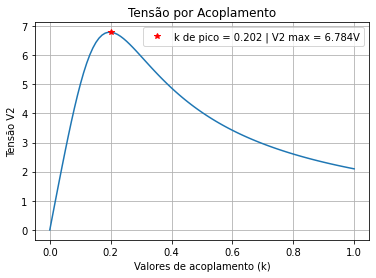

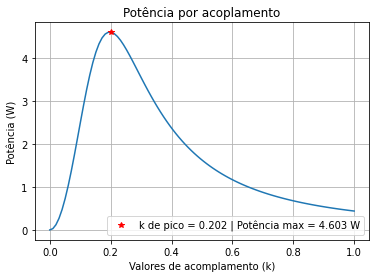

In [46]:
lista_k = np.linspace(0, 1, 100)
lista_V2 = []
lista_potencia = []
for k in lista_k:
    w=2*pi*f
    L1 = L2 =1/(w*w*C1)
    XC1 = XC2 = 1/(C1*1j*w)
    R1 = Rdc1
    R2 = Rdc2
    i1, i2 = CalcularCorrentes_(10, Rc, f, k)
    i4 = ((XC2*i2)/(XC2+Rc))
    lista_V2.append(abs(Rc*i4))
    lista_potencia.append(abs(Rc*i4*i4))
    
k_max = lista_k[lista_V2.index(max(lista_V2))]
potencia = max(lista_potencia)
print(f'Valor de k que gera maior tensão na carga: {k_max:.3f}')
print(f'Tensão máxima atingida pelo k: {max(lista_V2):.3f} V')
print(f'Potência máxima atingida: {potencia:.3f} W')
plt.plot(lista_k, lista_V2)
plt.plot(k_max, max(lista_V2), '*r', label = f'k de pico = {k_max:.3f} | V2 max = {max(lista_V2):.3f}V')
plt.legend()
plt.xlabel("Valores de acoplamento (k)")
plt.ylabel("Tensão V2")
plt.title("Tensão por Acoplamento")
plt.grid()
plt.show()

plt.plot(lista_k, lista_potencia)
plt.plot(k_max, potencia, '*r', label = f'k de pico = {k_max:.3f} | Potência max = {potencia:.3f} W')
plt.legend()
plt.xlabel("Valores de acomplamento (k)")
plt.ylabel("Potência (W)")
plt.title("Potência por acoplamento")
plt.grid()
plt.show()

Alterando a tensão de entrada $V1$ da fonte: 

Tensão máxima atingida pelo V1 max: 13.568 V
Potência máxima atingida: 18.410 W


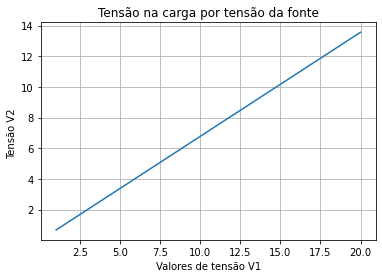

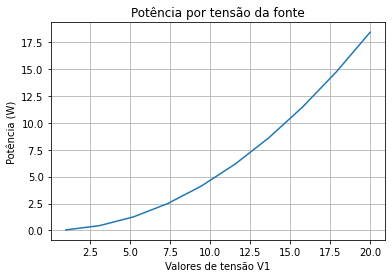

In [57]:
lista_tensao = np.linspace(1, 20, 10)
lista_V2 = []
lista_potencia = []
k = 0.202
for tensao in lista_tensao:
    w=2*pi*f
    L1 = L2 =1/(w*w*C1)
    XC1 = XC2 = 1/(C1*1j*w)
    R1 = Rdc1
    R2 = Rdc2
    i1, i2 = CalcularCorrentes_(tensao, Rc, f, k)
    i4 = ((XC2*i2)/(XC2+Rc))
    lista_V2.append(abs(Rc*i4))
    lista_potencia.append(abs(Rc*i4*i4))
v1_max = lista_tensao[lista_V2.index(max(lista_V2))]
potencia = max(lista_potencia)
print(f'Tensão máxima atingida pelo V1 max: {max(lista_V2):.3f} V')
print(f'Potência máxima atingida: {potencia:.3f} W')
plt.plot(lista_tensao, lista_V2)
plt.xlabel("Valores de tensão V1")
plt.ylabel("Tensão V2 ")
plt.title("Tensão na carga por tensão da fonte")
plt.grid()
plt.show()

plt.plot(lista_tensao, lista_potencia)
plt.xlabel("Valores de tensão V1")
plt.ylabel("Potência (W)")
plt.title("Potência por tensão da fonte")
plt.grid()
plt.show()

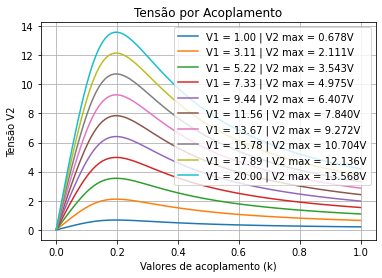

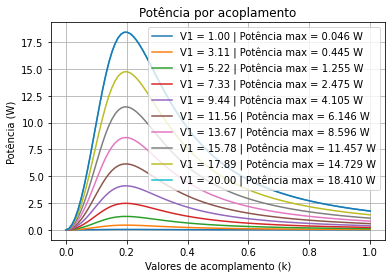

In [73]:
lista_k = np.linspace(0, 1, 100)
lista_tensao = np.linspace(1, 20, 10)
for tensao in lista_tensao:
    lista_V2 = []
    lista_potencia = []
    for k in lista_k:
        w=2*pi*f
        L1 = L2 =1/(w*w*C1)
        XC1 = XC2 = 1/(C1*1j*w)
        R1 = Rdc1
        R2 = Rdc2
        i1, i2 = CalcularCorrentes_(tensao, Rc, f, k)
        i4 = ((XC2*i2)/(XC2+Rc))
        lista_V2.append(abs(Rc*i4))
        lista_potencia.append(abs(Rc*i4*i4))
    v1_max = tensao
    plt.plot(lista_k, lista_V2,  label = f'V1 = {v1_max:.2f} | V2 max = {max(lista_V2):.3f}V')
plt.legend()
plt.xlabel("Valores de acoplamento (k)")
plt.ylabel("Tensão V2")
plt.title("Tensão por Acoplamento")
plt.grid()
plt.show()


for tensao in lista_tensao:
    lista_V2 = []
    lista_potencia = []
    for k in lista_k:
        w=2*pi*f
        L1 = L2 =1/(w*w*C1)
        XC1 = XC2 = 1/(C1*1j*w)
        R1 = Rdc1
        R2 = Rdc2
        i1, i2 = CalcularCorrentes_(tensao, Rc, f, k)
        i4 = ((XC2*i2)/(XC2+Rc))
        lista_V2.append(abs(Rc*i4))
        lista_potencia.append(abs(Rc*i4*i4))
    v1_max = tensao
    potencia = max(lista_potencia)
    plt.plot(lista_k, lista_potencia,  label = f'V1 = {v1_max:.2f} | Potência max = {potencia:.3f} W')

plt.plot(lista_k, lista_potencia)
plt.legend()
plt.xlabel("Valores de acomplamento (k)")
plt.ylabel("Potência (W)")
plt.title("Potência por acoplamento")
plt.grid()
plt.show()

Após análise dos gráficos observou-se que